# Imports

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pylab
import random
import tensorflow as tf
import wave

from pathlib import Path
from PIL import Image
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Variables & Hyperparameters

## Variables

In [2]:
DATA_TYPE = "gadf"
DIRECTORY = "/content/drive/MyDrive/Classes/CSCE 5222 Feature Engineering/Group Project/"
DATA_DIR = DIRECTORY + "2k-files/" + DATA_TYPE + "/"

## Hyperparameters

In [3]:
TRAIN_AMT = 200
VAL_AMT= 50
TEST_AMT = 50

IMG_H = 126 # 149 # 5980
IMG_W = 126 # 149 # 5980
N_CHANNELS = 3
N_CLASSES = 10

EPOCHS = 2
MAX_SIZE = 192
BATCH_SIZE = 10

# Load Dataset

## Train Generator

In [4]:
def gen_train():
    random.seed(42)

    # Get train ids
    data = []
    for j in range(1, 61):
        for i in range(10):
            for k in range(50):
                if j < 49:
                    n = str(j)
                    n = n.rjust(2, "0")
                    n = "%d_%s_%d"%(i, n, k)
                    data.append(n)

    # Iterate through ids
    random.shuffle(data)
    c = 0
    for i, n in enumerate(data):
        f_name = DATA_DIR + n + "_" + DATA_TYPE + ".jpg"
        try:

            # Load image
            img = tf.io.read_file(f_name)
            img = tf.io.decode_jpeg(img)   

        except:
            continue

        # Get y
        f = f_name.split("/")[-1]
        y = f.split("_")[-4]
        y = int(y)

        # Calculate padding
        s = img.shape
        # print(img.shape)
        if s[0] > MAX_SIZE:
            continue

        l = 0
        r = 0
        t = 0
        b = 0
        
        h = MAX_SIZE - img.shape[0]
        v = MAX_SIZE - img.shape[1]

        l = int((h) / 2)
        r = h - l
        t = int(( v) / 2)
        b = v - l

        # Pad
        img_p = tf.pad(img, tf.constant([[t, b], [l, r], [0, 0]]), "CONSTANT")

        # Convert to numpy
        img_p_n = img_p.numpy()

        # c += 1
        # if c > TRAIN_AMT:
        #     break

        yield img_p_n, y

## Validation Generator

In [5]:
def gen_val():
    random.seed(42)

    # Get train ids
    data = []
    for j in range(1, 61):
        for i in range(10):
            for k in range(50):
                if j > 48 and j < 55:
                    n = str(j)
                    n = n.rjust(2, "0")
                    n = "%d_%s_%d"%(i, n, k)
                    data.append(n)

    # Iterate through ids
    random.shuffle(data)
    c = 0
    for i, n in enumerate(data):
        f_name = DATA_DIR + n + "_" + DATA_TYPE + ".jpg"
        try:

            # Load image
            img = tf.io.read_file(f_name)
            img = tf.io.decode_jpeg(img)   

        except:
            continue

        # Get y
        f = f_name.split("/")[-1]
        y = f.split("_")[-4]
        y = int(y)

        # Calculate padding
        s = img.shape
        # print(img.shape)
        if s[0] > MAX_SIZE:
            continue

        l = 0
        r = 0
        t = 0
        b = 0
        
        h = MAX_SIZE - img.shape[0]
        v = MAX_SIZE - img.shape[1]

        l = int((h) / 2)
        r = h - l
        t = int(( v) / 2)
        b = v - l

        # Pad
        img_p = tf.pad(img, tf.constant([[t, b], [l, r], [0, 0]]), "CONSTANT")

        # Convert to numpy
        img_p_n = img_p.numpy()

        # c += 1
        # if c > VAL_AMT:
        #     break

        yield img_p_n, y

## Test Generator

In [6]:
def gen_test():
    random.seed(42)

    # Get train ids
    data = []
    for j in range(1, 61):
        for i in range(10):
            for k in range(50):
                if j > 54:
                    n = str(j)
                    n = n.rjust(2, "0")
                    n = "%d_%s_%d"%(i, n, k)
                    data.append(n)

    # Iterate through ids
    random.shuffle(data)
    c = 0
    for i, n in enumerate(data):
        f_name = DATA_DIR + n + "_" + DATA_TYPE + ".jpg"
        try:

            # Load image
            img = tf.io.read_file(f_name)
            img = tf.io.decode_jpeg(img)   

        except:
            continue

        # Get y
        f = f_name.split("/")[-1]
        y = f.split("_")[-4]
        y = int(y)

        # Calculate padding
        s = img.shape
        # print(img.shape)
        if s[0] > MAX_SIZE:
            continue

        l = 0
        r = 0
        t = 0
        b = 0
        
        h = MAX_SIZE - img.shape[0]
        v = MAX_SIZE - img.shape[1]

        l = int((h) / 2)
        r = h - l
        t = int((v) / 2)
        b = v - l

        # Pad
        img_p = tf.pad(img, tf.constant([[t, b], [l, r], [0, 0]]), "CONSTANT")

        # Convert to numpy
        img_p_n = img_p.numpy()
        
        # c += 1
        # if c > TEST_AMT:
        #     break

        yield img_p_n, y

## Datasets from Generators

In [7]:
# Build datasets
train = tf.data.Dataset.from_generator(gen_train, 
                                       output_signature=(tf.TensorSpec(shape=(MAX_SIZE, MAX_SIZE, 3), dtype=tf.uint8), 
                                                         tf.TensorSpec(shape=(), dtype=tf.uint8)
                                                         )
                                       )
val = tf.data.Dataset.from_generator(gen_val, 
                                     output_signature=(tf.TensorSpec(shape=(MAX_SIZE, MAX_SIZE, 3), dtype=tf.uint8), 
                                                       tf.TensorSpec(shape=(), dtype=tf.uint8)
                                                       )
                                     )
test = tf.data.Dataset.from_generator(gen_test, 
                                      output_signature=(tf.TensorSpec(shape=(MAX_SIZE, MAX_SIZE, 3), dtype=tf.uint8), 
                                                        tf.TensorSpec(shape=(), dtype=tf.uint8)
                                                        )
                                      )


In [8]:
# Batch
train = train.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls = tf.data.AUTOTUNE)
val = val.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls = tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls = tf.data.AUTOTUNE)

# Model

## Class

In [9]:
class Trainer():

    def __init__(self, name):
        self.name = name

    def build_model(self, img_height, img_width, n_channels, n_classes):
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Input(shape=(img_height, img_width, n_channels)))
        self.model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

        # Compile model
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.RMSprop(),
            metrics=['accuracy'],
        )

    def train_model_dataset(self, train_dataset, val_dataset, epochs):
        self.history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    def test_model_dataset(self, test_dataset, verbose=True):
        preds =  self.model.predict(test_dataset)
        preds_select = np.apply_along_axis(np.argmax, 1, preds)

        loss, acc = self.model.evaluate(test_dataset, verbose=2)
        
        true = []
        for e in test_dataset.as_numpy_iterator():
            for n in e[1]:
                true.append(n)

        scores = precision_recall_fscore_support(true, preds_select, average='macro')
        pre = scores[0]
        re = scores[1]
        f1 = scores[2]

        cm_labels = [x for x in range(10)]
        cm = confusion_matrix(true, preds_select, labels=cm_labels)

        if verbose:
            print("\nModel Results:")
            print("Loss: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\nF1: %f"%(loss, acc, pre, re, f1))
            print("\nConfusion Matrix:")
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
            disp.plot()

        return loss, acc, pre, re, f1, preds, cm

    def plot_loss(self):
        # Plot the loss curves for training and validation.
        history_dict = self.history.history
        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        epochs = range(1, len(loss_values)+1)

        plt.figure(figsize=(8,6))
        plt.plot(epochs, loss_values, 'bo', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        # Plot the accuracy curves for training and validation.
        history_dict = self.history.history
        acc_values = history_dict['accuracy']
        val_acc_values = history_dict['val_accuracy']
        epochs = range(1, len(acc_values)+1)

        plt.figure(figsize=(8,6))
        plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
        plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

## Training

In [ ]:
for i in range(2):
    x = test.take(1)
    y = x.get_single_element()[1]
    print(y)

### Epochs = 2

#### GADF

In [33]:
DATA_TYPE = "gadf"
DIRECTORY = "/content/drive/MyDrive/Classes/CSCE 5222 Feature Engineering/Group Project/"
DATA_DIR = DIRECTORY + "2k-files/" + DATA_TYPE + "/"

In [ ]:
# Build
model = Trainer(DATA_TYPE)
model.build_model(MAX_SIZE, MAX_SIZE, N_CHANNELS, N_CLASSES)

In [ ]:
# Train
model.train_model_dataset(train, val, EPOCHS)

Epoch 1/2
1956/1956 [==============================] - 8504s 4s/step - loss: 2.3329 - accuracy: 0.2029 - val_loss: 2.2759 - val_accuracy: 0.1890
Epoch 2/2
1956/1956 [==============================] - 265s 135ms/step - loss: 2.0250 - accuracy: 0.2677 - val_loss: 2.4671 - val_accuracy: 0.2634


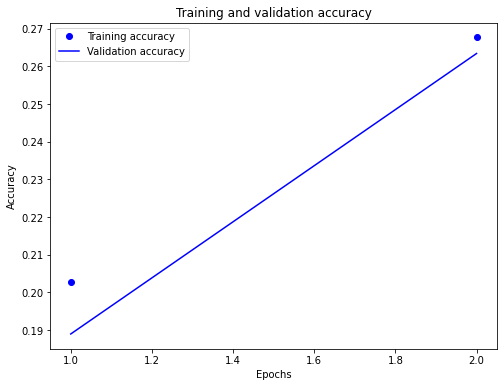

In [ ]:
# Plot training accuracy
model.plot_accuracy()

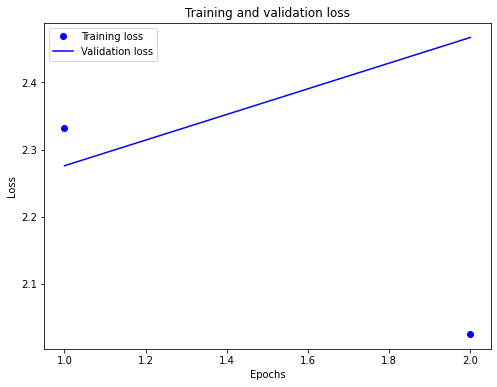

In [ ]:
# Plot training loss
model.plot_loss()

235/235 [==============================] - 942s 4s/step
235/235 - 27s - loss: 3.2312 - accuracy: 0.2106 - 27s/epoch - 116ms/step

Model Results:
Loss: 3.231215
Accuracy: 0.210638
Precision: 0.211630
Recall: 0.183799
F1: 0.152265

Confusion Matrix:


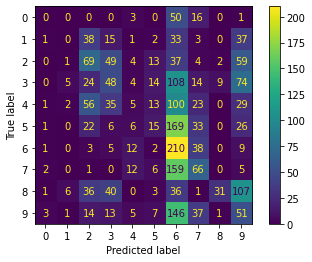

In [ ]:
# Get test scores
_ = model.test_model_dataset(test)

#### GASF

In [12]:
DATA_TYPE = "gasf"
DATA_DIR = DIRECTORY + "2k-files/" + DATA_TYPE + "/"

In [13]:
# Builds
model = Trainer(DATA_TYPE)
model.build_model(MAX_SIZE, MAX_SIZE, N_CHANNELS, N_CLASSES)

In [14]:
# Train
model.train_model_dataset(train, val, EPOCHS)

Epoch 1/2
1955/1955 [==============================] - 9441s 5s/step - loss: 2.2808 - accuracy: 0.2129 - val_loss: 4.1377 - val_accuracy: 0.1260
Epoch 2/2
1955/1955 [==============================] - 230s 118ms/step - loss: 2.0189 - accuracy: 0.2704 - val_loss: 4.7218 - val_accuracy: 0.2608


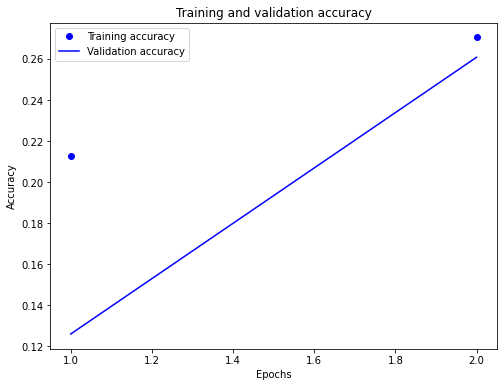

In [15]:
# Plot training accuracy
model.plot_accuracy()

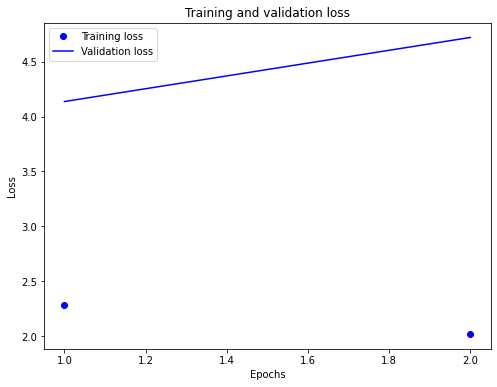

In [16]:
# Plot training loss
model.plot_loss()

236/236 [==============================] - 1061s 4s/step
236/236 - 22s - loss: 3.3358 - accuracy: 0.2403 - 22s/epoch - 94ms/step

Model Results:
Loss: 3.335766
Accuracy: 0.240254
Precision: 0.197739
Recall: 0.214635
F1: 0.183014

Confusion Matrix:


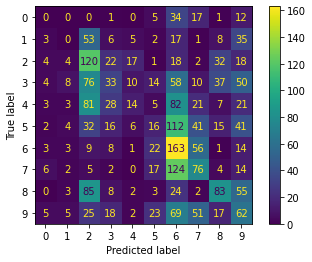

In [17]:
# Get test scores
_ = model.test_model_dataset(test)

### Epochs = 10

In [20]:
EPOCHS = 10

#### GADF

In [21]:
DATA_TYPE = "gadf"
DIRECTORY = "/content/drive/MyDrive/Classes/CSCE 5222 Feature Engineering/Group Project/"
DATA_DIR = DIRECTORY + "2k-files/" + DATA_TYPE + "/"

In [22]:
# Build
model = Trainer(DATA_TYPE)
model.build_model(MAX_SIZE, MAX_SIZE, N_CHANNELS, N_CLASSES)

In [23]:
# Train
model.train_model_dataset(train, val, EPOCHS)

Epoch 1/10
1956/1956 [==============================] - 9301s 5s/step - loss: 2.3112 - accuracy: 0.2112 - val_loss: 2.1321 - val_accuracy: 0.2273
Epoch 2/10
1956/1956 [==============================] - 227s 116ms/step - loss: 2.0219 - accuracy: 0.2710 - val_loss: 2.2163 - val_accuracy: 0.2427
Epoch 3/10
1956/1956 [==============================] - 230s 118ms/step - loss: 1.9536 - accuracy: 0.2959 - val_loss: 2.1540 - val_accuracy: 0.2683
Epoch 4/10
1956/1956 [==============================] - 239s 122ms/step - loss: 1.9197 - accuracy: 0.3041 - val_loss: 1.9805 - val_accuracy: 0.2811
Epoch 5/10
1956/1956 [==============================] - 239s 122ms/step - loss: 1.8905 - accuracy: 0.3202 - val_loss: 2.2265 - val_accuracy: 0.2678
Epoch 6/10
1956/1956 [==============================] - 226s 115ms/step - loss: 1.8627 - accuracy: 0.3286 - val_loss: 1.9656 - val_accuracy: 0.2956
Epoch 7/10
1956/1956 [==============================] - 234s 113ms/step - loss: 1.8260 - accuracy: 0.3472 - val_lo

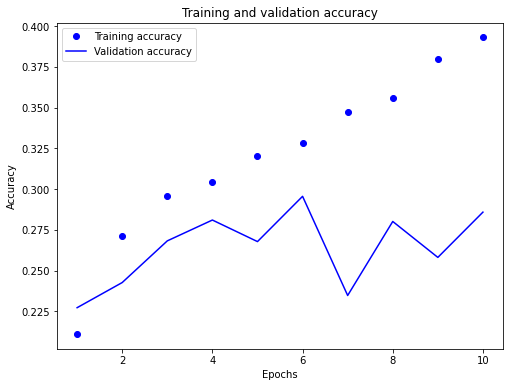

In [24]:
# Plot training accuracy
model.plot_accuracy()

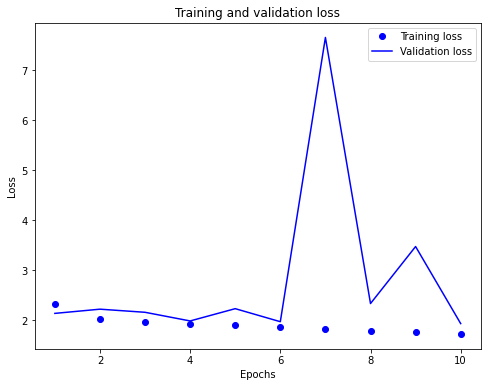

In [25]:
# Plot training loss
model.plot_loss()

235/235 [==============================] - 1085s 5s/step
235/235 - 26s - loss: 2.1706 - accuracy: 0.2021 - 26s/epoch - 112ms/step

Model Results:
Loss: 2.170637
Accuracy: 0.202128
Precision: 0.221538
Recall: 0.189075
F1: 0.158970

Confusion Matrix:


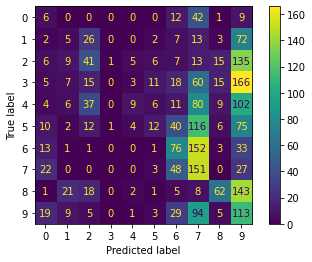

In [26]:
# Get test scores
_ = model.test_model_dataset(test)

#### GASF

In [34]:
DATA_TYPE = "gasf"
DATA_DIR = DIRECTORY + "2k-files/" + DATA_TYPE + "/"

In [28]:
# Builds
model = Trainer(DATA_TYPE)
model.build_model(MAX_SIZE, MAX_SIZE, N_CHANNELS, N_CLASSES)

In [29]:
# Train
model.train_model_dataset(train, val, EPOCHS)

Epoch 1/10
1955/1955 [==============================] - 239s 122ms/step - loss: 2.2847 - accuracy: 0.2060 - val_loss: 2.7150 - val_accuracy: 0.2132
Epoch 2/10
1955/1955 [==============================] - 216s 111ms/step - loss: 2.0388 - accuracy: 0.2625 - val_loss: 3.3172 - val_accuracy: 0.2485
Epoch 3/10
1955/1955 [==============================] - 235s 120ms/step - loss: 2.0060 - accuracy: 0.2791 - val_loss: 2.3773 - val_accuracy: 0.2758
Epoch 4/10
1955/1955 [==============================] - 248s 127ms/step - loss: 1.9520 - accuracy: 0.2961 - val_loss: 5.2121 - val_accuracy: 0.2824
Epoch 5/10
1955/1955 [==============================] - 273s 140ms/step - loss: 1.9096 - accuracy: 0.3139 - val_loss: 4.8280 - val_accuracy: 0.2991
Epoch 6/10
1955/1955 [==============================] - 201s 103ms/step - loss: 1.8725 - accuracy: 0.3281 - val_loss: 6.2694 - val_accuracy: 0.2656
Epoch 7/10
1955/1955 [==============================] - 202s 103ms/step - loss: 1.8415 - accuracy: 0.3444 - val_

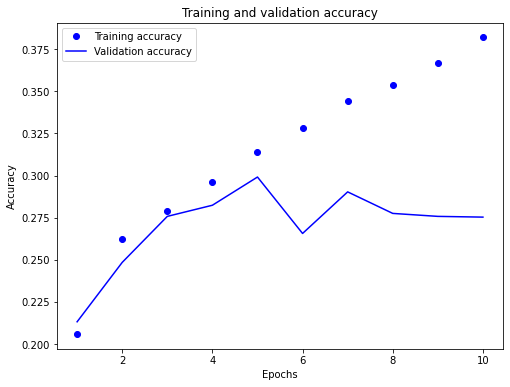

In [30]:
# Plot training accuracy
model.plot_accuracy()

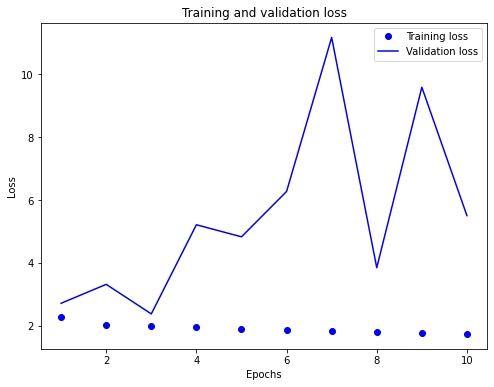

In [31]:
# Plot training loss
model.plot_loss()

236/236 [==============================] - 26s 110ms/step
236/236 - 24s - loss: 3.7669 - accuracy: 0.2229 - 24s/epoch - 103ms/step

Model Results:
Loss: 3.766896
Accuracy: 0.222881
Precision: 0.218572
Recall: 0.206050
F1: 0.190465

Confusion Matrix:


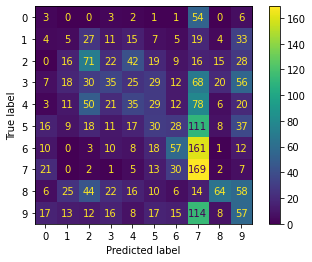

In [32]:
# Get test scores
_ = model.test_model_dataset(test)

# Bottom